In [2]:
pip install matplotlib

     |████████████████████████████████| 7.2 MB 594 kB/s eta 0:00:01     |████████████████████████████▏   | 6.3 MB 321 kB/s eta 0:00:03
     |████████████████████████████████| 2.8 MB 937 kB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 61 kB 430 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
     |████████████████████████████████| 32.1 MB 96 kB/s eta 0:00:011     |███████████████▏                | 15.3 MB 171 kB/s eta 0:01:39     |████████████████████████        | 24.1 MB 1.3 MB/s eta 0:00:07
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

## Setting max displayed rows to 500, in order to display the full output of any command
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [11]:
pip install sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
     |████████████████████████████████| 7.3 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 1.9 MB/s eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done
Note: you may need to restart the kernel to use updated packages.


In [51]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer

# pour afficher les pipelines
from sklearn import set_config
set_config(display='diagram')

# Fonctions de préparation

In [13]:
def log_prep_train_data(df):
    data = df.copy()
    # passage en catégoriel d'une variable numérique
    data["MSSubClass"] = data["MSSubClass"].astype(dtype="object")
    # log sur la target
    data["Log_SalePrice"] = np.log(data["SalePrice"])
    # outliers - drop des rows
    outliers_index = data[(data['LotArea'] > 100000) |
                (data["MasVnrArea"] > 1500) |
                (data['MiscVal']>6000) |
                (data['3SsnPorch']>350) |
                (data['EnclosedPorch']>400) |
                (data['OpenPorchSF']>450) |
                (data['1stFlrSF']>4000) |
                (data['TotalBsmtSF']>5000) |
                (data['GrLivArea']>4700)].index
    data = data.drop(outliers_index)
    # séparation X et y. Drop de LotFrontage où trop de valeurs manquantes
    X = data.drop(["Id", "LotFrontage", "SalePrice", "Log_SalePrice"], axis=1)
    y = data["Log_SalePrice"]
    return X, y

In [14]:
def name_cols(X):
    ordinal_cols = ["LotShape", "Utilities", "LandSlope", "Neighborhood", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
                "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual",
               "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive",
               "PoolQC", "Fence"]
    cat_cols = [col for col in X.columns if X[col].dtype == "object"]
    ohe_cols = [col for col in cat_cols if col not in ordinal_cols]
    num_cols = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
    return ordinal_cols, cat_cols, ohe_cols, num_cols

In [15]:
def prep_test_data(df):
    data = df.copy()
    data["MSSubClass"] = data["MSSubClass"].astype(dtype="object")
    X = data.drop(["Id", "LotFrontage"], axis=1)
    return X

# Chargement des données et utlisation des fonctions de préparation

In [18]:
train_path = "/Users/marie/Ecole_IA/Brief_5_PCA/data/train.csv"
train = pd.read_csv(train_path)

test_path = "/Users/marie/Ecole_IA/Brief_5_PCA/data/test.csv"
test = pd.read_csv(test_path)

In [19]:
X_train, y_train = log_prep_train_data(train)
X_train.shape

(1446, 78)

In [20]:
X_test = prep_test_data(test)
X_test.shape

(1459, 78)

In [24]:
ordinal_cols, cat_cols, ohe_cols, num_cols = name_cols(X_test)
assert len(ordinal_cols) + len(ohe_cols) + len(num_cols) == X_test.shape[1]
assert len(ordinal_cols) + len(ohe_cols) == len(cat_cols)

In [26]:
print(len(ohe_cols))

23


# Visualisation des problématiques de multicolinéarité que l'on peut chercher à résoudre avec la PCA
Rajouter le VIF ?

<AxesSubplot:>

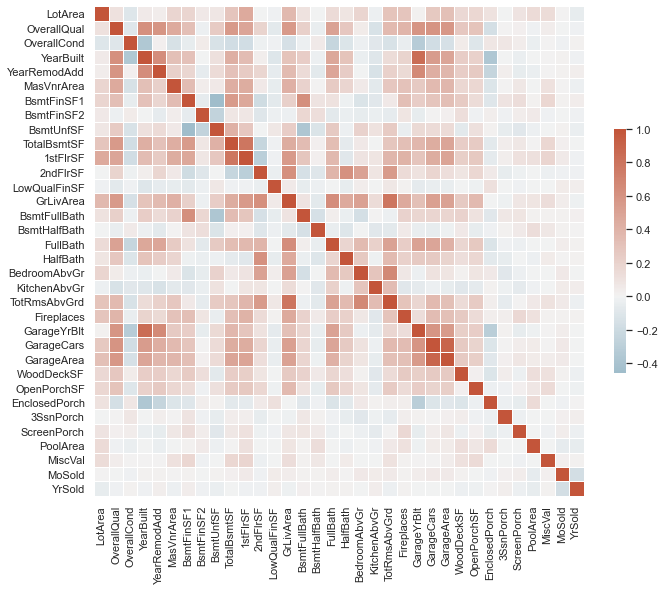

In [57]:
# Compute the correlation matrix
corr = X_test.corr()

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Préprocessing

## Préprocessing ordinal

In [27]:
# ATTENTION FAIT APPEL AU DATAFRAME TRAIN (il ne faut pas qu'il fasse appel au test)

# créer liste ordonnée des modalités de Neighborhood en fonction du prix de vente
ordonned_neighborhood_df = train[["Neighborhood", "SalePrice"]].groupby(["Neighborhood"], as_index=False).mean()
ordonned_neighborhood_df = ordonned_neighborhood_df.sort_values(by="SalePrice")

ordonned_neighborhood = list(ordonned_neighborhood_df["Neighborhood"])


# listes ordonnées pour encodage ordinal : 
ordinal_codes = [["IR3", "IR2", "IR1", "Reg"], 
        ["ELO", "NoSeWa", "NoSewr", "AllPub"], 
        ["Sev", "Mod", "Gtl"], 
        ordonned_neighborhood, 
        ["Po", "Fa", "TA", "Gd", "Ex"], 
        ["Po", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "Po", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "Po", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "No", "Mn", "Av", "Gd"], 
        ["Missing", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], 
        ["Missing", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"], 
        ["Po", "Fa", "TA", "Gd", "Ex"],
        ["N", "Y"], 
        ["Po", "Fa", "TA", "Gd", "Ex"],
        ["Missing", "Po", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "Unf", "RFn", "Fin"], 
        ["Missing", "Po", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "Po", "Fa", "TA", "Gd", "Ex"], 
        ["N", "P", "Y"], 
        ["Missing", "Fa", "TA", "Gd", "Ex"], 
        ["Missing", "MnWw", "GdWo", "MnPrv", "GdPrv"]]
assert len(ordinal_codes) == len(ordinal_cols)


In [42]:
# imputer données manquantes :
ordinal_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
X_train_ordinal_imputed = ordinal_imputer.fit_transform(X_train[ordinal_cols])

In [41]:
# encoder feature catégorielles en ordinal :
ordinal_encoder = OrdinalEncoder(categories = ordinal_codes, handle_unknown = "use_encoded_value", unknown_value=-1)
# remettre dans un dataframe avec les noms de features
X_train_ordinal_encoded = ordinal_encoder.fit_transform(X_train_ordinal_imputed)
X_train_ordinal_encoded_df = pd.DataFrame(X_train_ordinal_encoded, columns = ordinal_cols) 
X_train_ordinal_encoded_df

,LotShape,Utilities,LandSlope,Neighborhood,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,3.0,3.0,2.0,16.0,3.0,2.0,4.0,3.0,1.0,6.0,1.0,4.0,1.0,3.0,0.0,2.0,3.0,3.0,2.0,0.0,0.0
1,3.0,3.0,2.0,20.0,2.0,2.0,4.0,3.0,4.0,5.0,1.0,4.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0,0.0
2,2.0,3.0,2.0,16.0,3.0,2.0,4.0,3.0,2.0,6.0,1.0,4.0,1.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0,0.0
3,2.0,3.0,2.0,17.0,2.0,2.0,3.0,4.0,1.0,5.0,1.0,3.0,1.0,3.0,4.0,1.0,3.0,3.0,2.0,0.0,0.0
4,2.0,3.0,2.0,24.0,3.0,2.0,4.0,3.0,3.0,6.0,1.0,4.0,1.0,3.0,3.0,2.0,3.0,3.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,3.0,3.0,2.0,14.0,2.0,2.0,4.0,3.0,1.0,1.0,1.0,4.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0,0.0,0.0
1442,3.0,3.0,2.0,13.0,2.0,2.0,4.0,3.0,1.0,5.0,3.0,2.0,1.0,2.0,3.0,1.0,3.0,3.0,2.0,0.0,3.0
1443,3.0,3.0,2.0,17.0,4.0,3.0,3.0,4.0,1.0,6.0,1.0,4.0,1.0,3.0,4.0,2.0,3.0,3.0,2.0,0.0,4.0
1444,3.0,3.0,2.0,10.0,2.0,2.0,3.0,3.0,2.0,6.0,3.0,3.0,1.0,3.0,0.0,1.0,3.0,3.0,2.0,0.0,0.0


## Préprocessing One Hot

In [45]:
# imputer données manquantes :
ohe_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
X_train_ohe_imputed = ohe_imputer.fit_transform(X_train[ohe_cols])
X_train_ohe_imputed_df = pd.DataFrame(X_train_ohe_imputed, columns = ohe_cols)
X_train_ohe_imputed_df

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,MiscFeature,SaleType,SaleCondition
0,60,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,Missing,WD,Normal
1,20,RL,Pave,Missing,Lvl,FR2,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,SBrkr,Typ,Attchd,Missing,WD,Normal
2,60,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,Missing,WD,Normal
3,70,RL,Pave,Missing,Lvl,Corner,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,SBrkr,Typ,Detchd,Missing,WD,Abnorml
4,60,RL,Pave,Missing,Lvl,FR2,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,Missing,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,60,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,SBrkr,Typ,Attchd,Missing,WD,Normal
1442,20,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,CBlock,GasA,SBrkr,Min1,Attchd,Missing,WD,Normal
1443,70,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Stone,GasA,SBrkr,Typ,Attchd,Shed,WD,Normal
1444,20,RL,Pave,Missing,Lvl,Inside,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,CBlock,GasA,FuseA,Typ,Attchd,Missing,WD,Normal


In [49]:
# encoder features catégorielles avec get_dummies pour conserver noms des features :
X_train_ohe_encoded_df = pd.get_dummies(X_train_ohe_imputed_df)
X_train_ohe_encoded_df.shape

(1446, 162)

## Préprocessing Numérique

In [67]:
# imputer données manquantes :
num_imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_num_imputed = num_imputer.fit_transform(X_train[num_cols])
X_train_num_imputed_df = pd.DataFrame(X_train_num_imputed, columns = num_cols)

**Deux possibilités à tester pour scaler les variables numériques (contrainte ==> centrées autour de 0) :**
- Contrainte : données centrées autour de 0
- Normalement fait directement par la méthode PCA de sklearn
- A tester :
    - StandardScaler
    - Soustraction de la moyenne à chaque ligne (voir livre ML)
    - Ne rien faire pour voir comment se comporte la méthode sklearn

In [58]:
# StandardScaler :
num_scaler = StandardScaler()
X_train_num_scaled = num_scaler.fit_transform(X_train_num_imputed)
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns = num_cols)
X_train_num_scaled_df.shape

(1446, 34)

# COURS PCA

### LIENS Utiles
- https://www.kaggle.com/hassanamin/principal-component-analysis-with-code-examples/notebook
- https://www.kaggle.com/vipulgandhi/pca-beginner-s-guide-to-dimensionality-reduction ==> TOP pour cours. Reprend les bases du bouquin ML et va plus loin (eigenvalues). J'ai téléchargé le notebook.
- https://www.kaggle.com/miguelangelnieto/pca-and-regression : exemple avec Sales Prices


### Intérêt de la PCA

### Points de vigilance
- ne fonctionne que sur les variables quantitatives continues ==> pas de catégorielles
- ne fonctionne que sur des données centrées autour de 0 (la PCA de sklearn se charge de le faire)


### Mise en oeuvre de la PCA (théorie)

<br><br>**1) On détermine les vecteurs supports des axes :**
- Le premier axe est celui pour lequel la projection des variables sur cet axe conserve la plus grande part de variance (on peut aussi dire qu'il s'agit de l'axe qui minimise la moyenne du carré des distances entre les données d'origine et leurs projections)
- Ensuite on passe au second axe, orthogonal au premier, qui contribue le plus à la variance résiduelle. Et ainsi de suite jusqu'à ce qu'il ne reste plus de variance résiduelle à expliquer.

<br><br> **2) On détermine le nombre de dimensions :**
- L'objectif est ensuite de déterminer le nombre d'axes à choisir pour conserver (représenter) le max de la variance du dataset (ie perdre le moins d'information) tout en parvenant à l'objectif de réduction de la dimensionnalité. Pour ca on utilise sous sklearn les outils **d'explained_variance_ratio** et la **pca.get_covariance**  

# PCA sur les features numériques

## Identification des composantes principales

In [62]:
# PCA sur le X numérique - méthode en utilisant numpy
# on prend le X numérique scalé autour de 0 grâce au standard scaler
X_train_num_scaled_array = X_train_num_scaled_df.values
U, s, Vt = np.linalg.svd(X_train_num_scaled_array) # svd = Singular Value Decomposition. 
# svd : c'est l'équation de décomposition de la matrice X qui permet d'en extraire la matrice de composantes principales
c1 = Vt.T[:, 0] # vecteur unitaire définissant la première composante principale
c2 = Vt.T[:, 1] # et la seconde CP
c1

array([ 0.15281504,  0.30807113, -0.07878004,  0.23414915,  0.20454417,
        0.20108688,  0.12935609, -0.01192562,  0.12066889,  0.25769036,
        0.25798692,  0.14304685, -0.01691441,  0.30964926,  0.06836545,
       -0.01187418,  0.26562848,  0.13325081,  0.12104078, -0.01796215,
        0.25060462,  0.19164872,  0.1526448 ,  0.29973954,  0.2873855 ,
        0.13918593,  0.15744039, -0.07587539,  0.01876706,  0.03688836,
        0.02753927, -0.02316121,  0.02946443, -0.01555765])

## Projection  sur d dimensions

In [72]:
# matrice des deux vecteurs supports des deux premières CP
W2 = Vt.T[:, :2]
# produit scalaire de X avec cette matrice
X2D = X_train_num_scaled_array.dot(W2)
X2D # shape = (1446, 2) => on a réduit notre jeu de données à 2 dimensions

array([[ 1.33565549, -0.36337859],
       [-0.03938682,  1.07449678],
       [ 1.59390182, -0.23657424],
       ...,
       [ 0.73174742, -3.38241878],
       [-2.62654107,  1.98717071],
       [-0.75058771,  1.51585464]])

In [66]:
# matrice des deux vecteurs supports des 4 premières CP
W4 = Vt.T[:, :4]
# produit scalaire de X avec cette matrice
X4D = X_train_num_scaled_array.dot(W4)
X4D.shape # shape = (1446, 2) => on a réduit notre jeu de données à 4 dimensions

(1446, 4)

# Utilisation de SKLearn et choix éclairé du nombre de dimensions

## PCA.fit_transform

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D_V2 = pca.fit_transform(X_train_num_imputed_df)
X2D_V2

array([[-1584.08208592,    59.67196805],
       [ -433.97461225,   -66.67838704],
       [ 1215.22196465,    87.42532106],
       ...,
       [ -962.36352338,   774.73833563],
       [ -349.5166804 ,  -614.36266381],
       [ -100.14795721,  -182.76914229]])

In [74]:
X2D_V3 = pca.fit_transform(X_train_num_scaled_df)
X2D_V3 # identique au résultat du calcul fait avec numpy.

array([[ 1.33565572,  0.36329267],
       [-0.03938501, -1.07451034],
       [ 1.59390149,  0.23661656],
       ...,
       [ 0.73174795,  3.38308967],
       [-2.62654111, -1.98718331],
       [-0.75058753, -1.515771  ]])

## Exploration des paramètres et méthodes de la PCA

### Identification du nombre de dimensions permettant de contribuer à 95% de la variance des features
- Matrice de covariance des features : vecteurs propres correspondent aux composantes principales, valeurs propres correspondent au % de variance du modèle contenu dans la composante principale.
- **pca.explained_variance_ratio_** renvoie un array de ces valeurs propres. On peut en faire la somme cumulative pour voir l'évolution de la proportion de variance totale expliquée par le modèle au fur et à mesure de l'ajout des dimensions.
- on peut ploter cette somme cumulative de la pca_explained_variance_ratio pour identifier le nombre oprimal de dimensions (au moment où on a une cassure sur la courbe)


In [81]:
pca = PCA() # on instancie sans fixer le n_components
pca.fit(X_train_num_scaled_df)
pca.explained_variance_ratio_

array([2.00861900e-01, 9.24689598e-02, 6.16406868e-02, 5.66791642e-02,
       4.25313571e-02, 3.78506409e-02, 3.49621356e-02, 3.40989216e-02,
       3.34680240e-02, 3.18475688e-02, 3.15160739e-02, 2.98593305e-02,
       2.84206577e-02, 2.77453354e-02, 2.64772128e-02, 2.51348446e-02,
       2.43170786e-02, 2.25050137e-02, 2.12758914e-02, 1.93143663e-02,
       1.88905602e-02, 1.73825491e-02, 1.66442545e-02, 1.12779781e-02,
       1.03339069e-02, 9.44019912e-03, 8.40108115e-03, 7.68480360e-03,
       5.79906981e-03, 4.41872995e-03, 3.92318747e-03, 2.82851610e-03,
       3.96130251e-32, 5.24522257e-33])

In [96]:
print("la première composante principale explique:", int(round(pca.explained_variance_ratio_[0],2)*100),"% de la variance")
print("la seconde composante principale explique:", int(round(pca.explained_variance_ratio_[1],2)*100),"% de la variance")
print("la troisième composante principale explique:", int(round(pca.explained_variance_ratio_[2],2)*100),"% de la variance")
print("=="*35)
print("les 3 premières composantes principales expliquent:", int(round(pca.explained_variance_ratio_[0:3].sum(),2)*100),"% de la variance")

la première composante principale explique: 20 % de la variance
la seconde composante principale explique: 9 % de la variance
la troisième composante principale explique: 6 % de la variance
les 3 premières composantes principales expliquent: 35 % de la variance


In [83]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.2008619 , 0.29333086, 0.35497155, 0.41165071, 0.45418207,
       0.49203271, 0.52699484, 0.56109377, 0.59456179, 0.62640936,
       0.65792543, 0.68778476, 0.71620542, 0.74395076, 0.77042797,
       0.79556281, 0.81987989, 0.84238491, 0.8636608 , 0.88297516,
       0.90186572, 0.91924827, 0.93589253, 0.94717051, 0.95750441,
       0.96694461, 0.97534569, 0.9830305 , 0.98882957, 0.9932483 ,
       0.99717148, 1.        , 1.        , 1.        ])

In [89]:
d = np.argmax(cumsum >= 0.95) + 1
d # nombre de dimensions pour lesquelles la variance est au total de plus de 95%

25

In [90]:
pca = PCA(n_components = d)
X_reduced = pca.fit_transform(X_train_num_scaled_df)
X_reduced

array([[ 1.33565549,  0.36337859, -0.34952978, ...,  0.17635637,
         0.1218418 , -0.07689826],
       [-0.03938682, -1.07449678,  0.9348292 , ..., -0.56155494,
         0.36450873, -0.14245181],
       [ 1.59390182,  0.23657424, -0.43993254, ...,  0.7079971 ,
        -0.3784877 ,  0.11480332],
       ...,
       [ 0.73174742,  3.38241878,  2.44769949, ...,  0.7505057 ,
         0.68311557, -0.36181495],
       [-2.62654107, -1.98717071,  2.02793535, ..., -0.28067519,
        -0.0778855 , -0.46916738],
       [-0.75058771, -1.51585464,  2.23693891, ..., -0.64745102,
         0.25855302, -0.94030788]])

### Représentation graphique de cumsum

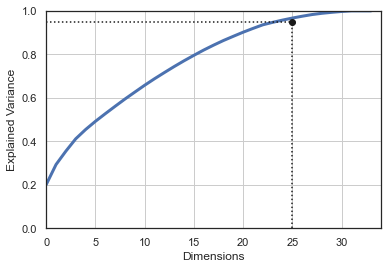

In [93]:
# code du livre d'A Géron
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, X_train_num_scaled_df.shape[1], 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
#plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             #arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### Autre représentation graphique :

In [98]:
pca.components_

array([[ 1.52815040e-01,  3.08071125e-01, -7.87800403e-02,
         2.34149153e-01,  2.04544167e-01,  2.01086876e-01,
         1.29356094e-01, -1.19256167e-02,  1.20668885e-01,
         2.57690365e-01,  2.57986923e-01,  1.43046845e-01,
        -1.69144121e-02,  3.09649260e-01,  6.83654548e-02,
        -1.18741831e-02,  2.65628479e-01,  1.33250807e-01,
         1.21040783e-01, -1.79621517e-02,  2.50604621e-01,
         1.91648716e-01,  1.52644801e-01,  2.99739541e-01,
         2.87385498e-01,  1.39185928e-01,  1.57440393e-01,
        -7.58753866e-02,  1.87670607e-02,  3.68883581e-02,
         2.75392711e-02, -2.31612108e-02,  2.94644295e-02,
        -1.55576507e-02],
       [-2.94798502e-03, -3.28138437e-02,  5.12426960e-02,
        -1.94661323e-01, -8.34870673e-02, -3.24498143e-02,
        -3.27012225e-01, -7.64624781e-02,  1.43949892e-01,
        -2.17567599e-01, -1.56993591e-01,  4.14561250e-01,
         1.27765739e-01,  2.49486560e-01, -3.14446901e-01,
        -8.42544778e-03,  1.47

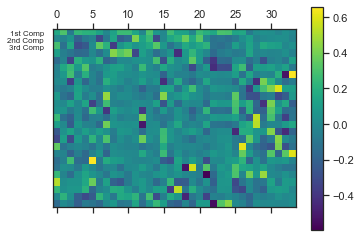

In [97]:
# heat-plot to see how the features mixed up to create the components.

plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=8)
plt.colorbar()
# plt.xticks(range(len(df_main.columns)),df_main.columns,rotation=65,ha='left')
# plt.tight_layout()
plt.show()

### Représentation graphique des données selon les composantes principales (obj = identifier des patterns)
#### Composantes principales n°1 et 2

In [ ]:
def pca1(xDF, yDF):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Attractivité"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Attractivité", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Séparation des observations en utilisant l'ACP (2 premiers vecteurs)")
    plt.plot([-1.5, 2.0], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 2.0], color='grey', ls='--')

In [ ]:
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

pca1(X_train_PCA, y_train)

In [ ]:
# Soustraction de la moyenne (à faire) :
X_train_num_

In [16]:
# imputer données manquantes :
num_imputer = SimpleImputer(strategy="constant", fill_value=0)

# scaler les variables numériques :
num_scaler = MinMaxScaler()

# NUMERICAL PIPELINE :
num_pipe = Pipeline([("num_imputer", num_imputer), ("num_scaler", num_scaler)])

## Pipeline de prépro global

In [93]:
prepro = ColumnTransformer([("ohe_pipe", ohe_pipe, ohe_cols), ("num_pipe", num_pipe, num_cols), ("ordinal_pipe", ordinal_pipe, ordinal_cols)])
prepro.get_params()

{'n_jobs': None,
 'remainder': 'drop',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('ohe_pipe',
   Pipeline(steps=[('ohe_imputer',
                    SimpleImputer(fill_value='Missing', strategy='constant')),
                   ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))]),
   ['MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LandContour',
    'LotConfig',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'Electrical',
    'Functional',
    'GarageType',
    'MiscFeature',
    'SaleType',
    'SaleCondition']),
  ('num_pipe',
   Pipeline(steps=[('num_imputer',
                    SimpleImputer(fill_value=0, strategy='constant')),
                   ('num_scaler', MinMaxScaler())]),
   ['LotArea',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',

# Modèles et pipes associés

In [94]:
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [95]:
model_ridge = Ridge()
pipe_ridge = Pipeline([("prepro", prepro), ("model_ridge", model_ridge)])

In [96]:
model_svr = SVR()
pipe_svr = Pipeline([("prepro", prepro), ("model_svr", model_svr)])

In [97]:
model_forest = RandomForestRegressor()
pipe_forest = Pipeline([("prepro", prepro), ("model_forest", model_forest)])

In [98]:
model_lassocv = LassoCV()
pipe_lassocv = Pipeline([("prepro", prepro), ("lasso_cv", model_lassocv)])

# Définition de la métrique
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [35]:
from sklearn.metrics import make_scorer, mean_squared_log_error, mean_squared_error
import math

In [36]:
def custom_score_log(y_true, y_pred):
    return math.sqrt(mean_squared_log_error(y_true, y_pred))

log_rmse = make_scorer(custom_score_log, greater_is_better=False)

In [37]:
def custom_score(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))


classic_rmse= make_scorer(custom_score, greater_is_better=False)

# Ridge

## Entrainement et prédiction sans split (Ridge)

In [42]:
X, y = log_prep_train_data(train)

In [43]:
pipe_ridge.fit(X, y)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('ohe_pipe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LandContour', 'LotConfig',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Roof...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-999))]),
                                                  ['LotShape', 'Utilities',
                                                   'LandSlope', 'Neighborhood',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'CentralAir', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence'])])),
                ('model_ridge', Ridge())])

In [44]:
cross_val_score(pipe_ridge, X_train, y_train, scoring=classic_rmse)

array([-0.11535955, -0.15321363, -0.13058881, -0.11493633, -0.11670488])

## Entrainement et prédiction avec split (Ridge)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [101]:
pipe_ridge.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('ohe_pipe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LandContour', 'LotConfig',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Roof...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LotShape', 'Utilities',
                                                   'LandSlope', 'Neighborhood',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'CentralAir', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence'])])),
                ('model_ridge', Ridge())])

In [102]:
cross_val_score(pipe_ridge, X_train, y_train, scoring=classic_rmse)

array([-0.12196351, -0.11388988, -0.13571353, -0.15703203, -0.11267503])

In [103]:
y_pred = pipe_ridge.predict(X_val)

In [104]:
custom_score(y_val, y_pred)

0.12508814703906207

## Optimisation du modèle Ridge :
Randomized Search + Grid Search
<br>Ensemble

In [64]:
pipe_ridge.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prepro', 'model_ridge', 'prepro__n_jobs', 'prepro__remainder', 'prepro__sparse_threshold', 'prepro__transformer_weights', 'prepro__transformers', 'prepro__verbose', 'prepro__ohe_pipe', 'prepro__num_pipe', 'prepro__ordinal_pipe', 'prepro__ohe_pipe__memory', 'prepro__ohe_pipe__steps', 'prepro__ohe_pipe__verbose', 'prepro__ohe_pipe__ohe_imputer', 'prepro__ohe_pipe__ohe_encoder', 'prepro__ohe_pipe__ohe_imputer__add_indicator', 'prepro__ohe_pipe__ohe_imputer__copy', 'prepro__ohe_pipe__ohe_imputer__fill_value', 'prepro__ohe_pipe__ohe_imputer__missing_values', 'prepro__ohe_pipe__ohe_imputer__strategy', 'prepro__ohe_pipe__ohe_imputer__verbose', 'prepro__ohe_pipe__ohe_encoder__categories', 'prepro__ohe_pipe__ohe_encoder__drop', 'prepro__ohe_pipe__ohe_encoder__dtype', 'prepro__ohe_pipe__ohe_encoder__handle_unknown', 'prepro__ohe_pipe__ohe_encoder__sparse', 'prepro__num_pipe__memory', 'prepro__num_pipe__steps', 'prepro__num_pipe__verbose', 'prepro__num_pi

In [99]:
from sklearn.model_selection import RandomizedSearchCV
distributions_ridge = dict(model_ridge__solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"], model_ridge__max_iter = np.arange(100, 10000, 100), model_ridge__alpha = np.linspace(0,1))

ridge_search = RandomizedSearchCV(pipe_ridge, distributions_ridge, random_state=0, scoring=classic_rmse)
ridge_search.fit(X_train, y_train)



RandomizedSearchCV(estimator=Pipeline(steps=[('prepro',
                                              ColumnTransformer(transformers=[('ohe_pipe',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Missing',
                                                                                                              strategy='constant')),
                                                                                               ('ohe_encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['MSSubClass',
                                                                                'MSZoning',
                                                                                'Street',
                                                                                'Alley',
                                                                                'LandContour',
                                                                                'LotConfig',
                                                                                'Condition1',
                                                                                'Condition2',
                                                                                'BldgType',
                                                                                '...
       5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600,
       6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700,
       7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800,
       8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900]),
                                        'model_ridge__solver': ['auto', 'svd',
                                                                'cholesky',
                                                                'lsqr',
                                                                'sparse_cg',
                                                                'sag',
                                                                'saga']},
                   random_state=0,
                   scoring=make_scorer(custom_score, greater_is_better=False))

In [100]:
print(f"Best Score : {ridge_search.best_score_}")
print(f"Best Parameters : {ridge_search.best_params_}")

Best Score : -0.12843732904810506
Best Parameters : {'model_ridge__solver': 'cholesky', 'model_ridge__max_iter': 5100, 'model_ridge__alpha': 0.9387755102040816}


# SVR

## Entrainement et prédiction avec split

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [106]:
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('ohe_pipe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LandContour', 'LotConfig',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Roof...
                                                                                               'GdPrv']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['LotShape', 'Utilities',
                                                   'LandSlope', 'Neighborhood',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'CentralAir', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence'])])),
                ('model_svr', SVR())])

In [107]:
cross_val_score(pipe_svr, X_train, y_train, scoring=classic_rmse)

array([-0.16146011, -0.13563572, -0.14455032, -0.1458673 , -0.13460105])

In [108]:
y_pred = pipe_svr.predict(X_val)

In [109]:
custom_score(y_val, y_pred)

0.1474950174302717

## Optimisation du modèle - à faire

### Randomized Search

In [83]:
pipe_svr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prepro', 'model_svr', 'prepro__n_jobs', 'prepro__remainder', 'prepro__sparse_threshold', 'prepro__transformer_weights', 'prepro__transformers', 'prepro__verbose', 'prepro__ohe_pipe', 'prepro__num_pipe', 'prepro__ordinal_pipe', 'prepro__ohe_pipe__memory', 'prepro__ohe_pipe__steps', 'prepro__ohe_pipe__verbose', 'prepro__ohe_pipe__ohe_imputer', 'prepro__ohe_pipe__ohe_encoder', 'prepro__ohe_pipe__ohe_imputer__add_indicator', 'prepro__ohe_pipe__ohe_imputer__copy', 'prepro__ohe_pipe__ohe_imputer__fill_value', 'prepro__ohe_pipe__ohe_imputer__missing_values', 'prepro__ohe_pipe__ohe_imputer__strategy', 'prepro__ohe_pipe__ohe_imputer__verbose', 'prepro__ohe_pipe__ohe_encoder__categories', 'prepro__ohe_pipe__ohe_encoder__drop', 'prepro__ohe_pipe__ohe_encoder__dtype', 'prepro__ohe_pipe__ohe_encoder__handle_unknown', 'prepro__ohe_pipe__ohe_encoder__sparse', 'prepro__num_pipe__memory', 'prepro__num_pipe__steps', 'prepro__num_pipe__verbose', 'prepro__num_pipe

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [110]:
from sklearn.model_selection import RandomizedSearchCV
distributions_svr = dict(model_svr__kernel = ["linear", "poly", "rbf", "sigmoid", "precomputed"], model_svr__max_iter = np.arange(100, 10000, 100), model_svr__C = np.logspace(0.1,1000),model_svr__gamma = np.logspace(0.001,1), model_svr__epsilon = np.linspace(0,10))

svr_random_search = RandomizedSearchCV(pipe_svr, distributions_svr, random_state=0, scoring=classic_rmse)
svr_random_search.fit(X_train, y_train)



/Users/marie/opt/anaconda3/lib/python3.8/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Inp

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 188, in fit
    raise ValueError("Precomputed matrix must be a square matrix."
ValueError: Precomputed matrix must be a square matrix. Input is a 925x207 matrix.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model

RandomizedSearchCV(estimator=Pipeline(steps=[('prepro',
                                              ColumnTransformer(transformers=[('ohe_pipe',
                                                                               Pipeline(steps=[('ohe_imputer',
                                                                                                SimpleImputer(fill_value='Missing',
                                                                                                              strategy='constant')),
                                                                                               ('ohe_encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['MSSubClass',
                                                                                'MSZoning',
                                                                                'Street',
                                                                                'Alley',
                                                                                'LandContour',
                                                                                'LotConfig',
                                                                                'Condition1',
                                                                                'Condition2',
                                                                                'BldgType',
                                                                                '...
       4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500,
       5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600,
       6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700,
       7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800,
       8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900])},
                   random_state=0,
                   scoring=make_scorer(custom_score, greater_is_better=False))

In [111]:
print(f"Best Score : {svr_random_search.best_score_}")
print(f"Best Parameters : {svr_random_search.best_params_}")

Best Score : -0.3952177585140496
Best Parameters : {'model_svr__max_iter': 6300, 'model_svr__kernel': 'poly', 'model_svr__gamma': 1.328392853809027, 'model_svr__epsilon': 2.857142857142857, 'model_svr__C': inf}


# Random Forest

## Entrainement et prédiction avec split

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [86]:
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('ohe_pipe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('ohe_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSSubClass', 'MSZoning',
                                                   'Street', 'Alley',
                                                   'LandContour', 'LotConfig',
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Roof...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-999))]),
                                                  ['LotShape', 'Utilities',
                                                   'LandSlope', 'Neighborhood',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'CentralAir', 'KitchenQual',
                                                   'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive',
                                                   'PoolQC', 'Fence'])])),
                ('model_forest', RandomForestRegressor())])

In [87]:
cross_val_score(pipe_forest, X_train, y_train, scoring=classic_rmse)

array([-0.14841166, -0.14071319, -0.14335062, -0.15686144, -0.12119801])

In [88]:
y_pred = pipe_forest.predict(X_val)

In [89]:
custom_score(y_val, y_pred)

0.1340069933505423

## Optimisation des hyperparamètres - A faire

# Modèles d'ensemble - à faire